In [ ]:
Agenda (and Points to make it better) :
    
    teacher forcing
    
    attention model (in decoder)
    
    entity matrix as initializer 
    
    separatly determining (کسره آخر) , one separat predictor along with y  to backprop (attention of it maybe should the entire sentence)
    
    word2vec(actualy char2vec) of embedding of (LM  predicting the next char) for both decoder and enc embedding 

    using word2vec , SOP tagging , lematization , stemming  along others
    
    bidirectional for decoder
    
    removing # and $ from all @ 

    using LM (using LM weights in our G2P model)

    geting loss from backward and forward (ansamble)

    end of string , <bos> , <eos>  same thing for words 

    using more layer (nl) , nh , emb_sz , ...

In [90]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [91]:
from fastai.text import *

# Data pre-processing 
## (i think it is the most efficient way of doing that ) 

In [92]:
PATH = Path("D:/FAST.Ai/DL2/Data/translate")
TMP_PATH = PATH/'tmp'
TMP_PATH.mkdir(exist_ok=True)

In [93]:
fname = "giga-fren.release2.fixed"
en_fname = PATH/f'{fname}.en'
fr_fname = PATH/f'{fname}.fr'

In [5]:
re_eq = re.compile('^(Wh[^?.!]+\?)')
re_fq = re.compile('^([^?.!]+\?)')

lines = ((re_eq.search(eq) , re_fq.search(fq))
             for eq, fq in zip(open(en_fname, encoding='utf-8'), open(fr_fname, encoding='utf-8')))

In [6]:
qs = [(e.group(),f.group()) for e,f in lines if e and f]

KeyboardInterrupt: 

In [ ]:
qs.sort()
qs = qs[:500]

In [8]:
qs = qs[10:]

In [9]:
pickle.dump(qs , (PATH/"fr-en-qs-500.pkl").open('wb'))

In [94]:
qs = pickle.load((PATH/"fr-en-qs-500.pkl").open("rb"))

In [95]:
en_qs , fr_qs = zip(*qs)

In [96]:
en_df = pd.DataFrame(np.array(en_qs))
fr_df = pd.DataFrame(np.array(fr_qs))
en_df.head(3)

,0
0,"What ""designs"" and ""stringency levels"" have be..."
1,"What ""highest priority"" action has the Commiss..."
2,"What ""hook"" would you use to engage Jim in the..."


In [97]:
fr_df.columns = [1]
fr_df

,1
0,"· Quels sont les ""concepts et ""niveaux d'exige..."
1,Quelles mesures «prioritaires» la Commission a...
2,Quel « appât » utiliseriez-vous pour inciter J...
3,Quelles sont les « leçons » que nous avons ret...
4,Quelles « causes naturelles » peuvent amener d...
5,Quelle « personnalité » a-t-elle?
6,Quelles solutions « renouvelables » les élèves...
7,"Pour la Saint-Valentin : chocolats, fleurs ou ..."
8,Quelle est la capacité maximale de traitement ...
9,Quels sont les «points chauds» dont nous devri...


In [98]:
len(en_df[0][0])

60

we should have same size in our phonetic and grapheme 

In [99]:
en_df["en_len"] = en_df[0].apply(lambda x: len(x.split(" ")))

In [100]:
en_df.head(3)

,0,en_len
0,"What ""designs"" and ""stringency levels"" have be...",8
1,"What ""highest priority"" action has the Commiss...",33
2,"What ""hook"" would you use to engage Jim in the...",17


In [101]:
fr_df["fr_len"] = fr_df[1].apply(lambda x: len(x.split(" ")))

In [102]:
fr_df.head(3)

,1,fr_len
0,"· Quels sont les ""concepts et ""niveaux d'exige...",9
1,Quelles mesures «prioritaires» la Commission a...,36
2,Quel « appât » utiliseriez-vous pour inciter J...,15


In [103]:
en_fr_df = pd.concat([en_df,fr_df] , axis = 1) 
en_fr_df.head(3)

,0,en_len,1,fr_len
0,"What ""designs"" and ""stringency levels"" have be...",8,"· Quels sont les ""concepts et ""niveaux d'exige...",9
1,"What ""highest priority"" action has the Commiss...",33,Quelles mesures «prioritaires» la Commission a...,36
2,"What ""hook"" would you use to engage Jim in the...",17,Quel « appât » utiliseriez-vous pour inciter J...,15


In [104]:
idxs = en_fr_df.loc[(en_fr_df.en_len == en_fr_df.fr_len) & (en_fr_df.en_len < 90)].index

In [105]:
new_en_fr_df = en_fr_df.loc[idxs]

In [106]:
#new_en_fr_df.reset_index(inplace=True)

In [107]:
len(idxs)

100

In [108]:
number_of_sentences = len(idxs)
number_of_sentences

100

In [109]:
new_en_fr_df.head(3)

,0,en_len,1,fr_len
5,"What ""personality"" does it have?",5,Quelle « personnalité » a-t-elle?,5
17,What (if anything) appears to be working (and ...,13,"Le cas échéant, qu'est-ce qui semble fonctionn...",13
18,What (if anything) appears to be working (and ...,13,"Le cas échéant, qu’est-ce qui semble fonctionn...",13


# supposing len of longest word is 10

In [110]:
x_longest_word = 10

In [111]:
x_padding = "@@@@@@@@@@"

In [112]:
y_longest_word = 10

In [113]:
y_padding = "@@@@@@@@@@"

# spliting by space 

In [137]:
x = pd.DataFrame(list(new_en_fr_df[0].apply(lambda x: x.split(" "))))
x.head(2)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,What,"""personality""",does,it,have?,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,What,(if,anything),appears,to,be,working,(and,why),at,...,project,level?,None,None,None,None,None,None,None,None


In [138]:
y = pd.DataFrame(list(new_en_fr_df[1].apply(lambda x: x.split(" "))))
y.head(2)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Quelle,«,personnalité,»,a-t-elle?,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,Le,cas,"échéant,",qu'est-ce,qui,semble,fonctionner,(et,pourquoi),au,...,du,projet?,None,None,None,None,None,None,None,None


In [139]:
type(y[0][0])

str

# filling None by padding 

In [140]:
x.fillna(value=x_padding, inplace=True)

In [141]:
x.head(2)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,What,"""personality""",does,it,have?,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,...,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@
1,What,(if,anything),appears,to,be,working,(and,why),at,...,project,level?,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@


In [142]:
y.fillna(value=y_padding, inplace=True)

In [143]:
y.head(2)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,Quelle,«,personnalité,»,a-t-elle?,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,...,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@
1,Le,cas,"échéant,",qu'est-ce,qui,semble,fonctionner,(et,pourquoi),au,...,du,projet?,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@


# reshape to one column

In [144]:
np_x = x.values
np_x

array([['What', '"personality"', 'does', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@'],
       ['What', '(if', 'anything)', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@'],
       ['What', '(if', 'anything)', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@'],
       ...,
       ['What', 'Happens', 'When', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@'],
       ['What', 'Has', 'Changed', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@'],
       ['What', 'Heritage?', '@@@@@@@@@@@@@@@@', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@',
        '@@@@@@@@@@@@@@@@']], dtype=object)

In [145]:
new_x = pd.DataFrame(np_x.reshape(-1,1))
new_x.head(6)

,0
0,What
1,"""personality"""
2,does
3,it
4,have?
5,@@@@@@@@@@@@@@@@


### for y

In [146]:
np_y = y.values
np_y

array([['Quelle', '«', 'personnalité', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@'],
       ['Le', 'cas', 'échéant,', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@'],
       ['Le', 'cas', 'échéant,', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@'],
       ...,
       ["Qu'arrive-t-il", 'si', 'une', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@'],
       ['What', 'Has', 'Changed', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@'],
       ['What', 'Heritage?', '@@@@@@@@@@@@@@@@', ..., '@@@@@@@@@@@@@@@@', '@@@@@@@@@@@@@@@@',
        '@@@@@@@@@@@@@@@@']], dtype=object)

In [147]:
new_y = pd.DataFrame(np_y.reshape(-1,1))
new_y.head(6)

,0
0,Quelle
1,«
2,personnalité
3,»
4,a-t-elle?
5,@@@@@@@@@@@@@@@@


## ading "bow" and "eow" to our word 

In [148]:
edited_x = pd.DataFrame(list(new_x[0].apply(lambda x: "$" + x + "#" )))

In [149]:
edited_x.head(2)

,0
0,$What#
1,"$""personality""#"


In [150]:
char_by_char_x= pd.DataFrame(list(edited_x[0].apply(lambda x: list(x))))
char_by_char_x.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,$,W,h,a,t,#,None,None,None,None,None,None,None,None,None,None,None,None
1,$,"""",p,e,r,s,o,n,a,l,i,t,y,"""",#,None,None,None


In [151]:
len(char_by_char_x.loc[0])

18

### for y

In [152]:
edited_y = pd.DataFrame(list(new_y[0].apply(lambda x: "$" + x + "#" )))
edited_y.head(2)

,0
0,$Quelle#
1,$«#


In [153]:
char_by_char_y= pd.DataFrame(list(edited_y[0].apply(lambda x: list(x))))
char_by_char_y.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,$,Q,u,e,l,l,e,#,None,None,None,None,None,None,None,None,None,None
1,$,«,#,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


## so our x_longest_word was 16 and we should go back and doing all of them again

In [154]:
x_longest_word = len(char_by_char_x.loc[0]) - 2
x_longest_word

16

In [155]:
x_padding = ''
for i in range(x_longest_word):
    x_padding += "@"

In [133]:
len(x_padding)

16

### for y

In [134]:
y_longest_word = len(char_by_char_y.loc[0]) - 2
y_longest_word

16

In [135]:
y_padding = ''
for i in range(y_longest_word):
    y_padding += "@"

In [136]:
len(y_padding)

16

# filling Nones with @

In [156]:
char_by_char_x.fillna(value="@", inplace=True)

In [157]:
char_by_char_x.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,$,W,h,a,t,#,@,@,@,@,@,@,@,@,@,@,@,@
1,$,"""",p,e,r,s,o,n,a,l,i,t,y,"""",#,@,@,@


### for y

In [67]:
char_by_char_y.fillna(value="@", inplace=True)

In [68]:
char_by_char_y.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,$,Q,u,e,l,l,e,#,@,@,@,@,@,@,@,@,@,@
1,$,«,#,@,@,@,@,@,@,@,@,@,@,@,@,@,@,@


# reshaping to one sentence in a word 

In [69]:
len(char_by_char_x)

2100

In [70]:
last_x = pd.DataFrame(char_by_char_x.values.reshape(number_of_sentences , -1))

In [71]:
x_max_alpha_in_sentence =len(last_x.loc[0])
x_max_alpha_in_sentence

378

In [72]:
x_max_alpha_in_word = len(x_padding) +2
x_max_alpha_in_word

18

In [73]:
x_number_of_words = int(x_max_alpha_in_sentence / x_max_alpha_in_word)
x_number_of_words

21

### for y

In [74]:
len(char_by_char_y)

2100

In [75]:
last_y = pd.DataFrame(char_by_char_y.values.reshape(number_of_sentences , -1))

In [76]:
y_max_alpha_in_sentence =len(last_y.loc[0])
y_max_alpha_in_sentence

378

In [77]:
y_max_alpha_in_word = len(y_padding) +2
y_max_alpha_in_word

18

In [78]:
y_number_of_words = int(y_max_alpha_in_sentence / y_max_alpha_in_word)
y_number_of_words

21

# Loding numbers (just for this fren data) 

In [5]:
y_number_of_words , x_number_of_words = 21 , 21
y_max_alpha_in_word , x_max_alpha_in_word = 18 , 18
y_max_alpha_in_sentence , x_max_alpha_in_sentence = 378 , 378

# turnign DataFrames to numpy

In [79]:
x_tok = last_x.values
x_tok

array([['$', 'W', 'h', ..., '@', '@', '@'],
       ['$', 'W', 'h', ..., '@', '@', '@'],
       ['$', 'W', 'h', ..., '@', '@', '@'],
       ...,
       ['$', 'W', 'h', ..., '@', '@', '@'],
       ['$', 'W', 'h', ..., '@', '@', '@'],
       ['$', 'W', 'h', ..., '@', '@', '@']], dtype=object)

In [80]:
y_tok = last_y.values
y_tok

array([['$', 'Q', 'u', ..., '@', '@', '@'],
       ['$', 'L', 'e', ..., '@', '@', '@'],
       ['$', 'L', 'e', ..., '@', '@', '@'],
       ...,
       ['$', 'Q', 'u', ..., '@', '@', '@'],
       ['$', 'W', 'h', ..., '@', '@', '@'],
       ['$', 'W', 'h', ..., '@', '@', '@']], dtype=object)

# V3 concating all the columns to 1

In [81]:
cated_last_y = pd.DataFrame(last_y.apply(''.join, axis=1))

In [82]:
cated_last_y.loc[0]

0    $Quelle#@@@@@@@@@@$«#@@@@@@@@@@@@@@@$personnal...
Name: 0, dtype: object

In [83]:
cated_last_x = pd.DataFrame(last_x.apply(''.join, axis=1))

In [84]:
cated_last_y.columns = ["y"]

In [85]:
cated_last_x.columns = ["x"]

In [86]:
cated_df = pd.concat([cated_last_x,cated_last_y] , axis = 1) 

In [87]:
cated_df.to_pickle(PATH/'cated_df.pkl')

In [88]:
cated_df = pd.read_pickle(PATH/'cated_df.pkl')

# saving 

In [89]:
pickle.dump(x_tok, (PATH/'x_tok.pkl').open('wb'))
pickle.dump(y_tok, (PATH/'y_tok.pkl').open('wb'))

In [9]:
x_tok = pickle.load((PATH/'x_tok.pkl').open('rb'))
y_tok = pickle.load((PATH/'y_tok.pkl').open('rb'))

# toks2indexs

In [137]:
freq = Counter(p for o in x_tok for p in o)
itos = [o for o,c in freq.most_common(40000)]

In [140]:
itos[:5]

['@', '$', '#', 'e', 't']

In [91]:
def toks2ids(tok,pre):
    freq = Counter(p for o in tok for p in o)
    itos = [o for o,c in freq.most_common(40000)]
    itos.remove('@')
    itos.remove('$')
    itos.remove('#')
    
    itos.insert(0, '_bos_')
    itos.insert(1, '@') # padding
    itos.insert(2, '_eos_')
    itos.insert(3, '_unk')
    itos.insert(4, '$') # <bow>
    itos.insert(5, '#') # <eow>
    stoi = collections.defaultdict(lambda:3 , {v:k for k,v in enumerate(itos)})
    ids = np.array([[stoi[o] for o in p] for p in tok])
    np.save(TMP_PATH/f'{pre}_ids.npy', ids)
    pickle.dump(itos, open(TMP_PATH/f'{pre}_itos.pkl', 'wb'))
    return ids,itos,stoi

In [92]:
x_ids,x_itos,x_stoi = toks2ids(x_tok,'x')
y_ids,y_itos,y_stoi = toks2ids(y_tok,'y')

# loading indexes 

In [6]:
def load_ids(pre):
    ids = np.load(TMP_PATH/f'{pre}_ids.npy')
    itos = pickle.load(open(TMP_PATH/f'{pre}_itos.pkl', 'rb'))
    stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})
    return ids,itos,stoi

In [7]:
x_ids,x_itos,x_stoi = load_ids('x')
y_ids,y_itos,y_stoi = load_ids('y')

In [8]:
np.array([x_itos[o] for o in x_ids[0]])

array(['$', 'W', 'h', 'a', 't', '#', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '$', '"',
       'p', 'e', 'r', 's', 'o', 'n', 'a', 'l', 'i', 't', 'y', '"', '#', '@', '@', '@', '$', 'd', 'o', 'e',
       's', '#', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '$', 'i', 't', '#', '@', '@',
       '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '$', 'h', 'a', 'v', 'e', '?', '#', '@',
       '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '$', '@', '@', '@', '@', '@', '@', '@', '@', '@',
       '@', '#', '@', '@', '@', '@', '@', '@', '$', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '#',
       '@', '@', '@', '@', '@', '@', '$', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '#', '@', '@',
       '@', '@', '@', '@', '$', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '#', '@', '@', '@', '@',
       '@', '@', '$', '@', '@', '@', '@', '@', '@', '@', '@', '@', '@', '#', '@', '@', '@', '@', '@', '@',
       '$', '@', '@', '@', '@', '@', 

# Model Data

In [9]:
class Seq2SeqDataset(Dataset):
    def __init__(self, x, y): self.x,self.y = x,y
    def __getitem__(self, idx): return A(self.x[idx], self.y[idx])
    def __len__(self): return len(self.x)

In [10]:
np.random.seed(42)
trn_keep = np.random.rand(len(x_ids))>0.1
x_trn , y_trn = x_ids[trn_keep] ,y_ids[trn_keep]
x_val , y_val = x_ids[~trn_keep] ,y_ids[~trn_keep]

In [11]:
len(x_val) , len(x_trn)

(13, 87)

In [12]:
len(y_val) , len(y_trn)

(13, 87)

In [13]:
trn_ds = Seq2SeqDataset(x_trn,y_trn)
val_ds = Seq2SeqDataset(x_val,y_val)

In [14]:
bs = 64

In [15]:
trn_samp = SortishSampler(y_trn, key=lambda x: len(y_trn[x]), bs=bs)
val_samp = SortSampler(y_val, key=lambda x: len(y_val[x]))

In [16]:
trn_dl = DataLoader(trn_ds , bs , transpose=True , transpose_y=True,num_workers=1,pad_idx=1
                    ,pre_pad=False , sampler=trn_samp)
val_dl = DataLoader(val_ds , int(bs*1.6) , transpose=True , transpose_y=True,num_workers=1,pad_idx=1
                    ,pre_pad=False , sampler=val_samp)
md = ModelData(PATH,trn_dl,val_dl)

In [17]:
it =iter(trn_dl)
ne =next(it)

ne

[
     4     4     4  ...      4     4     4
    15    15    15  ...     15    15    15
    12    12    12  ...     12    12    12
        ...          ⋱          ...       
     1     1     1  ...      1     1     1
     1     1     1  ...      1     1     1
     1     1     1  ...      1     1     1
 [torch.LongTensor of size 378x64], 
     4     4     4  ...      4     4     4
    33    26    23  ...     37    23    26
     6    20    13  ...      9    13    20
        ...          ⋱          ...       
     1     1     1  ...      1     1     1
     1     1     1  ...      1     1     1
     1     1     1  ...      1     1     1
 [torch.LongTensor of size 378x64]]

# main model (heart of code)

In [ ]:
# check for turning again for longest word

# simple model 

In [21]:
def create_emb(itos,emb_sz):
    emb = nn.Embedding(len(itos),emb_sz)#,pad_idx=1
    return emb

In [22]:
nh , nl = 40 , 1
em_sz_enc , em_sz_dec = 10 , 10

In [23]:
 class G2P_1(nn.Module):
    def __init__(self, itos_enc, em_sz_enc, itos_dec, em_sz_dec, nh, out_sl, nl):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = create_emb( itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb( itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        print("\n enc_out:   " , enc_out.size())
        last_of_each_part = enc_out[x_max_alpha_in_word-1 :: x_max_alpha_in_word ,:,:]
        
        #print("\n last_of_each_part:   " , last_of_each_part.size() )
        
        h_last_of_each_part = self.out_enc(last_of_each_part)
        #print("\n h:   " , h.size())
        #print("\n h[1]:   " , h[1])
        dec_inp = V(torch.zeros(bs).long())
        
        final_res = []        
        for j in range(h_last_of_each_part.size()[0]):
            h = (h_last_of_each_part[j]).unsqueeze(dim=0)
            res = []
            for i in range(self.out_sl):
                emb = self.emb_dec(dec_inp).unsqueeze(0)
                #print("\n h[j]).unsqueeze:   " ,j)#,"    ",(h[j]).unsqueeze(dim=0).size())
                outp, h = self.gru_dec(emb , h)
                #print("\n h:   " , h.size())
                #print("\n first outp:   " , outp.size())
                #print("\n second outp:   " , outp[0].size())
                outp = self.out(self.out_drop(outp[0]))
                res.append(outp)
                dec_inp = V(outp.data.max(1)[1])
                #if (dec_inp==1).all(): break
            final_res.append(torch.stack(res))
                        
        #print("\n final_res:   " , torch.cat(final_res).size() )
        return torch.cat(final_res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [24]:
opt_fn = partial(optim.Adam,betas=(0.8,0.99))

rnn = G2P_1(x_itos,em_sz_enc,y_itos,em_sz_dec,nh, y_max_alpha_in_word ,nl)

In [25]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    #print("\n y_sl:   " , sl)
    #print("\n y_bs:   " , bs)
    
    sl_in,bs_in,nc = input.size()
    
    #print("\n x_sl:   " , sl_in)
    #print("\n x_bs:   " , bs_in)
    #if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    #input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [26]:
learn = RNN_Learner(md,SingleModel(rnn) , opt_fn=opt_fn)
#SingleModel treat the whole thing as a group , groups of lr

learn.crit = seq2seq_loss

In [27]:
lr = 1e-3

In [28]:
learn.fit(lr,1)

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]
 enc_out:    torch.Size([378, 64, 40])
 50%|████████████████████████████████████▌                                    | 1/2 [00:00<00:00,  1.63it/s, loss=5.44]
 enc_out:    torch.Size([378, 23, 40])
Validation:   0%|                                                                                | 0/1 [00:00<?, ?it/s]
 enc_out:    torch.Size([378, 13, 40])
epoch      trn_loss   val_loss                                                                                         
    0      5.420199   4.901486  



[array([4.90149])]

In [120]:
learn.save("GRU_last_of_each_uni_dir")

In [121]:
learn.load("GRU_last_of_each_uni_dir")

# F.pad (check that if it makes acc better add this for rest of models >> after this to the end )

In [30]:
def create_emb(itos,emb_sz):
    emb = nn.Embedding(len(itos),emb_sz)#,pad_idx=1
    return emb

In [31]:
nh , nl = 40 , 1
em_sz_enc , em_sz_dec = 10 , 10

In [32]:
 class G2P_1(nn.Module):
    def __init__(self, itos_enc, em_sz_enc, itos_dec, em_sz_dec, nh, out_sl, nl):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = create_emb( itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25)
        self.out_enc = nn.Linear(nh, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb( itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb, h)
        
        last_of_each_part = enc_out[x_max_alpha_in_word-1 :: x_max_alpha_in_word ,:,:]
        
        #print("\n last_of_each_part:   " , last_of_each_part.size() )
        
        h_last_of_each_part = self.out_enc(last_of_each_part)
        #print("\n h:   " , h.size())
        #print("\n h[1]:   " , h[1])
        dec_inp = V(torch.zeros(bs).long())
        
        final_res = []        
        for j in range(h_last_of_each_part.size()[0]):
            h = (h_last_of_each_part[j]).unsqueeze(dim=0)
            res = []
            for i in range(self.out_sl):
                emb = self.emb_dec(dec_inp).unsqueeze(0)
                #print("\n h[j]).unsqueeze:   " ,j)#,"    ",(h[j]).unsqueeze(dim=0).size())
                outp, h = self.gru_dec(emb, h)
                #print("\n h:   " , h.size())
                #print("\n first outp:   " , outp.size())
                #print("\n second outp:   " , outp[0].size())
                outp = self.out(self.out_drop(outp[0]))
                res.append(outp)
                dec_inp = V(outp.data.max(1)[1])
                if (dec_inp==1).all(): break
            stacked_res = torch.stack(res)
            sl = stacked_res.size()[0]
            stacked_res = F.pad(stacked_res, (0,0,0,0,0, self.out_sl-sl))
            final_res.append(stacked_res)
                        
        #print("\n final_res:   " , torch.cat(final_res).size() )
        return torch.cat(final_res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl, bs, self.nh))

In [33]:
opt_fn = partial(optim.Adam,betas=(0.8,0.99))

rnn = G2P_1(x_itos,em_sz_enc,y_itos,em_sz_dec,nh, y_max_alpha_in_word ,nl)

In [34]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    #print("\n y_sl:   " , sl)
    #print("\n y_bs:   " , bs)
    
    sl_in,bs_in,nc = input.size()
    
    #print("\n x_sl:   " , sl_in)
    #print("\n x_bs:   " , bs_in)
    #if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    #input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [35]:
learn = RNN_Learner(md,SingleModel(rnn) , opt_fn=opt_fn)
#SingleModel treat the whole thing as a group , groups of lr

learn.crit = seq2seq_loss

In [36]:
lr = 1e-3

In [37]:
learn.fit(lr,1)

epoch      trn_loss   val_loss                                                                                         
    0      4.022777   4.30795   



[array([4.30795])]

In [120]:
learn.save("GRU_last_of_each_uni_dir")

In [121]:
learn.load("GRU_last_of_each_uni_dir")

# Bidirectional G2P

# that was not bidirictional in all the sentence , just words

In [38]:
def create_emb(itos,emb_sz):
    emb = nn.Embedding(len(itos),emb_sz)#,pad_idx=1
    return emb

In [39]:
nh , nl = 40 , 1
em_sz_enc , em_sz_dec = 10 , 10

In [47]:
 class G2P_Bidir(nn.Module):
    def __init__(self, itos_enc, em_sz_enc, itos_dec, em_sz_dec, nh, out_sl, nl=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = create_emb( itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional = True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb( itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h_gru_enc = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        
        h_res = []
        for k in range(emb.size()[0]):
            enc_out, h_gru_enc = self.gru_enc(emb[k].unsqueeze(0) , h_gru_enc)
            h = h_gru_enc.view(self.nl,2,bs,-1).permute(0,2,1,3).contiguous().view(self.nl,bs,-1)
            h_res.append(h[0])
        
        h_res = torch.stack(h_res)
        
        first_of_each_part = h_res[0 :: x_max_alpha_in_word ,:,:]
        
        h_first_of_each_part = self.out_enc(first_of_each_part)
        
        dec_inp = V(torch.zeros(bs).long())
        final_res = []        
        for j in range(h_first_of_each_part.size()[0]):
            h = (h_first_of_each_part[j]).unsqueeze(dim=0)
            res = []
            for i in range(self.out_sl):
                emb = self.emb_dec(dec_inp).unsqueeze(0)
                outp, h = self.gru_dec(emb,h)
                outp = self.out(self.out_drop(outp[0]))
                res.append(outp)
                dec_inp = V(outp.data.max(1)[1])
                #if (dec_inp==1).all(): break
            final_res.append(torch.stack(res))
                        
        return torch.cat(final_res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [48]:
# make it first of each part  (check the number of that is = to  21)

In [49]:
opt_fn = partial(optim.Adam,betas=(0.8,0.99))

rnn = G2P_Bidir(x_itos,em_sz_enc,y_itos,em_sz_dec,nh, y_max_alpha_in_word ,nl)

In [50]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    #print("\n y_sl:   " , sl)
    #print("\n y_bs:   " , bs)
    
    sl_in,bs_in,nc = input.size()
    
    #print("\n x_sl:   " , sl_in)
    #print("\n x_bs:   " , bs_in)
    #if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    #input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [51]:
learn = RNN_Learner(md,SingleModel(rnn) , opt_fn=opt_fn)
#SingleModel treat the whole thing as a group , groups of lr

learn.crit = seq2seq_loss

In [52]:
lr = 1e-3

In [53]:
learn.fit(lr,1)

epoch      trn_loss   val_loss                                                                                         
    0      6.564824   6.175123  



[array([6.17512])]

In [117]:
learn.save("G2P_Bidir_first_of_each_part")

In [118]:
learn.load("G2P_Bidir_first_of_each_part")

# Bidir in entire sentence

In [18]:
def create_emb(itos,emb_sz):
    emb = nn.Embedding(len(itos),emb_sz)#,pad_idx=1
    return emb

In [19]:
nh , nl = 40 , 1
em_sz_enc , em_sz_dec = 10 , 10
bs = 64

In [72]:
 class G2P_entire_sntence_Bidir(nn.Module):
    def __init__(self, itos_enc, em_sz_enc, itos_dec, em_sz_dec, nh, out_sl, nl=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.emb_enc = create_emb( itos_enc, em_sz_enc)
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(em_sz_enc, nh, num_layers=nl, dropout=0.25, bidirectional = True)
        self.out_enc = nn.Linear(nh*2, em_sz_dec, bias=False)
        
        self.emb_dec = create_emb( itos_dec, em_sz_dec)
        self.gru_dec = nn.GRU(em_sz_dec, em_sz_dec, num_layers=nl, dropout=0.1)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(em_sz_dec, len(itos_dec))
        self.out.weight.data = self.emb_dec.weight.data
        
    def forward(self, inp):
        sl,bs = inp.size()
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        enc_out, h = self.gru_enc(emb , h)
        
        T1 = enc_out[0 :: x_max_alpha_in_word ,:, nh:]
        T2 = enc_out[x_max_alpha_in_word-1 :: x_max_alpha_in_word ,:, :nh]
        
        concated_enc_out = []
        for k in range(T1.size()[0]):
            concated_enc_out.append(torch.cat((T1[k] , T2[k]) , 1))
        
        concated_enc_out = torch.stack(concated_enc_out)                  
        h_concated_enc_out = self.out_enc(concated_enc_out)
        
        dec_inp = V(torch.zeros(bs).long())
        final_res = []        
        for j in range(h_concated_enc_out.size()[0]):
            h = (h_concated_enc_out[j]).unsqueeze(dim=0)
            res = []
            for i in range(self.out_sl):
                emb = self.emb_dec(dec_inp).unsqueeze(0)
                outp, h = self.gru_dec(emb,h)
                outp = self.out(self.out_drop(outp[0]))
                res.append(outp)
                dec_inp = V(outp.data.max(1)[1])
                #if (dec_inp==1).all(): break
            final_res.append(torch.stack(res))
                        
        return torch.cat(final_res)
    
    def initHidden(self, bs): return V(torch.zeros(self.nl*2, bs, self.nh))

In [73]:
opt_fn = partial(optim.Adam,betas=(0.8,0.99))

rnn = G2P_entire_sntence_Bidir(x_itos,em_sz_enc,y_itos,em_sz_dec,nh, y_max_alpha_in_word ,nl)

In [74]:
def seq2seq_loss(input, target):
    sl,bs = target.size()
    #print("\n y_sl:   " , sl)
    #print("\n y_bs:   " , bs)
    
    sl_in,bs_in,nc = input.size()
    
    #print("\n x_sl:   " , sl_in)
    #print("\n x_bs:   " , bs_in)
    #if sl>sl_in: input = F.pad(input, (0,0,0,0,0,sl-sl_in))
    #input = input[:sl]
    return F.cross_entropy(input.view(-1,nc), target.view(-1))#, ignore_index=1)

In [75]:
learn = RNN_Learner(md,SingleModel(rnn) , opt_fn=opt_fn)
#SingleModel treat the whole thing as a group , groups of lr

learn.crit = seq2seq_loss

epoch      trn_loss   val_loss                                                                                         
    0      5.288864   4.752321  



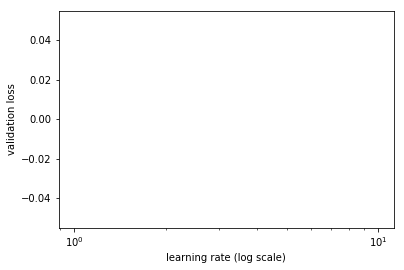

In [76]:
learn.lr_find()
learn.sched.plot()

In [79]:
lr = 1e-3

In [203]:
learn.fit(lr, 1, cycle_len=1)#, use_clr=(20,10))

epoch      trn_loss   val_loss                                                                                         
    0      5.12139    5.356619  



[array([5.35662])]

# Testing (val_set)

In [210]:
x,y = next(iter(val_dl))
probs = learn.model(V(x))

In [212]:
x.size()

torch.Size([378, 13])

In [211]:
probs.size()

torch.Size([378, 13, 79])

In [214]:
len(y_itos)

79

In [229]:
preds = to_np(probs.max(2)[1])
preds.shape

(378, 13)

In [236]:
for i in range(0,13):
    s = ""
    for j in range(x.size()[0]):
        temp_ch = x_itos[x[j,i]]
        if(x[j,i] == 1): continue
        elif((temp_ch == '$') or (temp_ch == '#')): s = s+" "
        else : s = s+temp_ch
    s += "\n"
    
    for j in range(y.size()[0]):
        temp_ch = y_itos[y[j,i]]
        if(y[j,i] == 1): continue
        elif((temp_ch == '$') or (temp_ch == '#')): s = s+" "
        else : s = s+temp_ch
    s += "\n"
    
    for j in range(preds.shape[0]):
        temp_ch = y_itos[preds[j,i]]
        if(preds[j,i] == 1): continue
        elif((temp_ch == '$') or (temp_ch == '#')): s = s+" "
        else : s = s+temp_ch
    s += "\n"
    
    print(s,"\n\n\n")

 What  ADR  services  does  the  Commission  provide?                             
 Quels  services  de  RAD  la  Commission  offre-t-elle?                             
tOOOOO0ccâcânccâncOOOO0ccâcânccânccân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc
 



 What  Alberta  legislation  covers  these  types  of  facilities?                           
 Quelles  lois  de  l’Alberta  visent  ces  types  d’établissement?                           
tOOOOO0ccâcânccâncOOOOO0ccâcânccânccOOOO0ccâcânccânccân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcâ

 



 What  Has  Changed  Since  the  Early  1980s?                             
 What  Has  Changed  Since  the  Early  1980s?                             
tOOOOO0ccâcânccânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcânc
 





# testing one item 

##  Prepairing Data of it 

In [159]:
test_inp = "what is that"

In [165]:
test_inp_df = pd.DataFrame(list(test_inp.split(" "))).transpose()
test_inp_df

,0,1,2
0,what,is,that


In [167]:
x_test_df = pd.DataFrame(x.iloc[0]).transpose()
x_test_df

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,What,"""personality""",does,it,have?,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,...,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@


In [170]:
df_x = pd.concat([test_inp_df,x_test_df] , axis = 0) 
df_x

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,what,is,that,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,What,"""personality""",does,it,have?,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,...,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@


In [172]:
df_x.fillna(value=x_padding, inplace=True)
df_x

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,what,is,that,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,...,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@
0,What,"""personality""",does,it,have?,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,...,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@,@@@@@@@@@@@@@@@@


In [175]:
np_x_test = df_x.values

In [179]:
new_x_test = pd.DataFrame(np_x_test.reshape(-1,1))
new_x_test.head(4)

,0
0,what
1,is
2,that
3,@@@@@@@@@@@@@@@@


In [180]:
edited_x_test = pd.DataFrame(list(new_x_test[0].apply(lambda x: "$" + x + "#" )))

In [181]:
edited_x_test.head(4)

,0
0,$what#
1,$is#
2,$that#
3,$@@@@@@@@@@@@@@@@#


In [183]:
char_x_test = pd.DataFrame(list(edited_x_test[0].apply(lambda x: list(x))))
char_x_test.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,$,w,h,a,t,#,None,None,None,None,None,None,None,None,None,None,None,None
1,$,i,s,#,None,None,None,None,None,None,None,None,None,None,None,None,None,None


In [184]:
char_x_test.fillna(value="@", inplace=True)

In [185]:
char_x_test.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,$,w,h,a,t,#,@,@,@,@,@,@,@,@,@,@,@,@
1,$,i,s,#,@,@,@,@,@,@,@,@,@,@,@,@,@,@


In [186]:
last_x_test = pd.DataFrame(char_x_test.values.reshape(2 , -1))
last_x_test

,0,1,2,3,4,5,6,7,8,9,...,368,369,370,371,372,373,374,375,376,377
0,$,w,h,a,t,#,@,@,@,@,...,@,@,@,@,@,@,@,@,@,#
1,$,W,h,a,t,#,@,@,@,@,...,@,@,@,@,@,@,@,@,@,#


In [189]:
np_x_test_item = last_x_test.loc[0].values

In [190]:
itos = pickle.load(open(TMP_PATH/f'x_itos.pkl', 'rb'))
stoi = collections.defaultdict(lambda: 3, {v:k for k,v in enumerate(itos)})

In [206]:
test_x_ids = np.array([[stoi[o] for o in p] for p in np_x_test_item])
test_x_ids = test_x_ids.reshape(-1,1)

In [207]:
t_test_x_ids = T(test_x_ids)
t_test_x_ids.size()

torch.Size([378, 1])

In [239]:
probs = learn.model(V(t_test_x_ids))

In [240]:
probs.size()

torch.Size([378, 1, 79])

In [241]:
preds = to_np(probs.max(2)[1])
preds.shape

(378, 1)

In [246]:
for i in range(0,t_test_x_ids.size()[1]):
    s = ""
    for j in range(t_test_x_ids.size()[0]):
        temp_ch = x_itos[t_test_x_ids[j,i]]
        if(t_test_x_ids[j,i] == 1): continue
        elif((temp_ch == '$') or (temp_ch == '#')): s = s+" "
        else : s = s+temp_ch
    s += "\n"
    
    for j in range(preds.shape[0]):
        temp_ch = y_itos[preds[j,i]]
        if(preds[j,i] == 1): continue
        elif((temp_ch == '$') or (temp_ch == '#')): s = s+" "
        else : s = s+temp_ch
    s += "\n"
    
    print(s,"\n\n\n")

 what  is  that                                     
tOOOOO0ccâcânccânc âân_eos__eos_OOOOOO0ccâcân_eos__eos_OOOOOOO0ccâcâncânccânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccâncccâânccânccânccân
 



